In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Using a pre-trained convnet

This notebook contains the code sample found in Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----
想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。 预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。举个例子，你在 ImageNet 上训练了一个网络（其类别主要是动物和日常用品），然后将这个训练好的网络应用于某个不相干的任务，比如在图像中识别家具。这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小数据问题非常有效。

本例中，假设有一个在 ImageNet 数据集（140 万张标记图像，1000 个不同的类别）上训练好的大型卷积神经网络。ImageNet 中包含许多动物类别，其中包括不同种类的猫和狗，因此可以认为它在猫狗分类问题上也能有良好的表现。

我们将使用 VGG16 架构，它由 Karen Simonyan 和 Andrew Zisserman 在 2014 年开发。对于ImageNet，它是一种简单而又广泛使用的卷积神经网络架构。虽然 VGG16 是一个比较旧的模 型，性能远比不了当前最先进的模型，而且还比许多新模型更为复杂，但我之所以选择它，是因为它的架构与你已经熟悉的架构很相似，因此无须引入新概念就可以很好地理解。这可能是你第一次遇到这种奇怪的模型名称——VGG、ResNet、Inception、Inception-ResNet、Xception 等。 你会习惯这些名称的，因为如果你一直用深度学习做计算机视觉的话，它们会频繁出现。

使用预训练网络有两种方法：特征提取（feature extraction）和微调模型（fine-tuning）。两种方法我们都会介绍。首先来看特征提取。

## Feature extraction

特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

如前所述，用于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。第一部分叫作模型的卷积基（convolutional base）。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面 训练一个新的分类器（见下图）。

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

为什么仅重复使用卷积基？我们能否也重复使用密集连接分类器？一般来说，应该避免这么做。原因在于卷积基学到的表示可能更加通用，因此更适合重复使用。卷积神经网络的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉问题，这种特征图都可能很有用。但是，分类器学到的表示必然是针对于模型训练的类别，其中仅包含某个类别出现在整张图像中的概率信息。此外，密集连接层的表示不再包含物体在输入图像中的位置信息。密集连接层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。如果物体位置对于问题 很重要，那么密集连接层的特征在很大程度上是无用的。

注意，某个卷积层提取的表示的通用性（以及可复用性）取决于该层在模型中的深度。模型中更靠近底部的层提取的是局部的、高度通用的特征图（比如视觉边缘、颜色和纹理），而更靠近顶部的层提取的是更加抽象的概念（比如“猫耳朵”或“狗眼睛”）。 因此，如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基。

本例中，由于 ImageNet 的类别中包含多种狗和猫的类别，所以重复使用原始模型密集连接层中所包含的信息可能很有用。但我们选择不这么做，以便涵盖新问题的类别与原始模型的类别不一致的更一般情况。

我们来实践一下，使用在 ImageNet 上训练的 VGG16 网络的卷积基从 猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。 VGG16 等模型内置于 Keras 中。你可以从 keras.applications 模块中导入。

下面是keras.applications 中的一部分图像分类模型（都是在 ImageNet 数据集上预训练得到的）：

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

这里向构造函数中传入了三个参数。

* weights 指定模型初始化的权重检查点。
* include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于 ImageNet 的 1000 个类别。因为我们打算使用自己的密集连接分类器（只有 两个类别：cat 和 dog），所以不需要包含它。
* input_shape 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传入这个参数，那么网络能够处理任意形状的输入。 

VGG16 卷积基的详细架构如下所示。它和你已经熟悉的简单卷积神经网络很相似。

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后的特征图形状为 (4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。 接下来，下一步有两种方法可供选择。

* 在你的数据集上运行卷积基，将输出保存成硬盘中的 Numpy 数组，然后用这个数据作 为输入，输入到独立的密集连接分类器中（与本书第一部分介绍的分类器类似）。这种 方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目 前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强。
* 在顶部添加 Dense 层来扩展已有模型（即 conv_base），并在输入数据上端到端地运行 整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多。

这两种方法我们都会介绍。首先来看第一种方法的代码：保存你的数据在 conv_base 中的输出，然后将这些输出作为输入用于新模型。

In [0]:
# 授权
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!ls


adc.json  cats_and_dogs_small.zip  sample_data


In [0]:
!unzip cats_and_dogs_small.zip

Archive:  cats_and_dogs_small.zip
   creating: cats_and_dogs_small/
   creating: cats_and_dogs_small/test/
   creating: cats_and_dogs_small/test/cats/
  inflating: cats_and_dogs_small/test/cats/cat.1500.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1501.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1502.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1503.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1504.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1505.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1506.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1507.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1508.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1509.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1510.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1511.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1512.jpg  
  inflating: cats_and_dogs_small/test/cats/cat.1513.jpg  
  inflating: cats_and_dogs_small/test

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/") #数据加载成功

In [0]:
!ls
#当前文件夹的位置发生了变化,想回到colab的原位置可以使用 ../


 Colab_book  'Colab Notebooks'	 data   Untitled0.ipynb


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            #注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前，提取的特征形状为 (samples, 4, 4, 512)。我们要将其输入到密集连接分类器中， 所以首先必须将其形状展平为 (samples, 8192)。

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

现在你可以定义你的密集连接分类器（注意要使用 dropout 正则化），并在刚刚保存的数据和标签上训练这个分类器

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 644us/step - loss: 0.5893 - acc: 0.6830 - val_loss: 0.4495 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 423us/step - loss: 0.4253 - acc: 0.8070 - val_loss: 0.3788 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 1s 450us/step - loss: 0.3561 - acc: 0.8560 - val_loss: 0.3285 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 445us/step - loss: 0.3125 - acc: 0.8765 - val_loss: 0.2999 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 1s 448us/step - loss: 0.2888 - acc: 0.8825 - val_loss: 0.2873 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 446us/step - loss: 0.2660 - acc: 0.8960 - val_loss: 0.2757 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 1s 449us/step - loss: 0.2532 - acc: 0.9010 - val_loss: 0.2690 - val_acc: 0.9010


训练速度非常快，因为你只需处理两个 Dense 层。即使在 CPU 上运行，每轮的时间也不到一秒钟。

我们来看一下训练期间的损失曲线和精度曲线

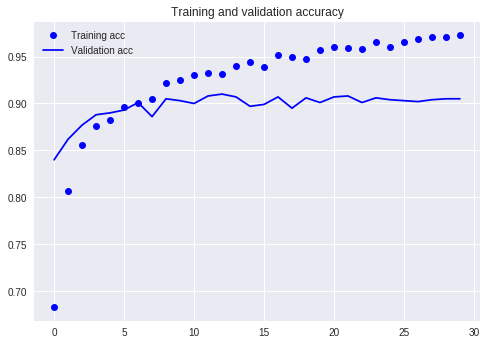

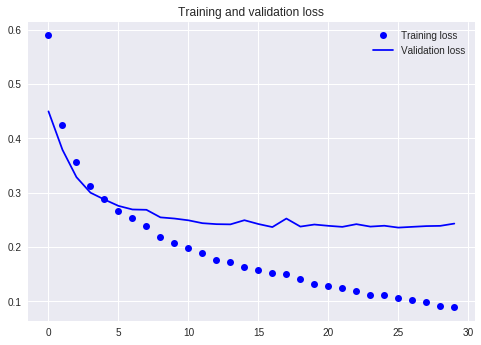

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


我们的验证精度达到了约 90%，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然 dropout 比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

下面我们来看一下特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展 conv_base 模型，然后在输入数据上端到端地运行模型。

模型的行为和层类似，所以你可以向 Sequential 模型中添加一个模型（比如 conv_base），就像添加一个层一样。

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


如你所见，VGG16 的卷积基有 14 714 688 个参数，非常多。在其上添加的分类器有 200 万个参数。

在编译和训练模型之前，一定要“冻结”卷积基。冻结（freeze）一个或多个层是指在训练 过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。 因为其上添加的 Dense 层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。

在 Keras 中，冻结网络的方法是将其 trainable 属性设为 False。

In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
# vgg本身有13个卷积层，加上两个Dense层，一共15层需要训练，每层两个权重向量（权重W和偏置b）

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [9]:
model.summary()
# 训练的参数数量大幅度下降

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


如此设置之后，只有添加的两个 Dense 层的权重才会被训练。总共有 4 个权重张量，每层2 个（主权重矩阵和偏置向量）。注意，为了让这些修改生效，你必须先编译模型。如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。

现在你可以开始训练模型了，使用和前一个例子相同的数据增强设置。

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 28s - loss: 0.6149 - acc: 0.6685 - val_loss: 0.4632 - val_acc: 0.8440
Epoch 2/30
 - 25s - loss: 0.4859 - acc: 0.7790 - val_loss: 0.3864 - val_acc: 0.8610
Epoch 3/30
 - 25s - loss: 0.4379 - acc: 0.8040 - val_loss: 0.3343 - val_acc: 0.8740
Epoch 4/30
 - 25s - loss: 0.4122 - acc: 0.8235 - val_loss: 0.3138 - val_acc: 0.8770
Epoch 5/30
 - 25s - loss: 0.3805 - acc: 0.8375 - val_loss: 0.2993 - val_acc: 0.8790
Epoch 6/30
 - 26s - loss: 0.3700 - acc: 0.8445 - val_loss: 0.2852 - val_acc: 0.8820
Epoch 7/30
 - 26s - loss: 0.3573 - acc: 0.8410 - val_loss: 0.2813 - val_acc: 0.8820
Epoch 8/30
 - 25s - loss: 0.3496 - acc: 0.8490 - val_loss: 0.2768 - val_acc: 0.8900
Epoch 9/30
 - 25s - loss: 0.3494 - acc: 0.8500 - val_loss: 0.2677 - val_acc: 0.8920
Epoch 10/30
 - 25s - loss: 0.3400 - acc: 0.8515 - val_loss: 0.2660 - val_acc: 0.8900
Epoch 11/30
 - 25s - loss: 0.3409 - acc: 0.8515 - val_loss: 0.2610 - val_ac

In [0]:
model.save('cats_and_dogs_small_ys_3.h5')

Let's plot our results again:

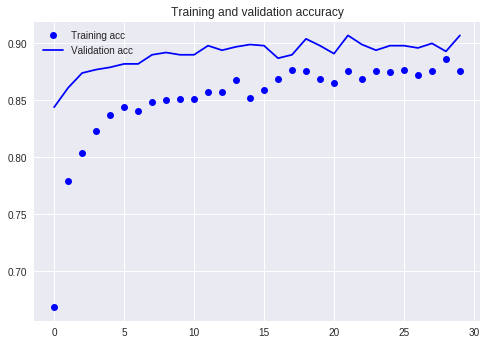

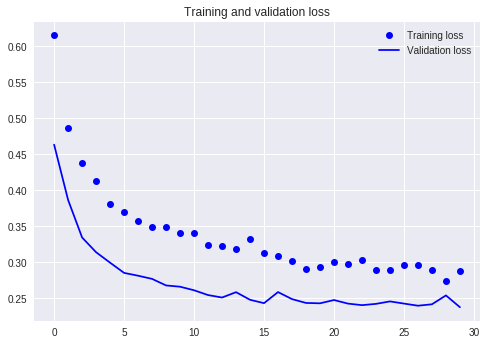

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

我们来再次绘制结果。如你所见，验证精度约为 96%。这比从头开始训练的小型卷积神经网络要好得多。

## Fine-tuning

另一种广泛使用的模型复用方法是模型微调（fine-tuning），与特征提取互为补充。对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练（见下图）。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

前面说过，冻结 VGG16 的卷积基是为了能够在上面训练一个随机初始化的分类器。同理， 只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。因此，微调网络的步骤如下。

* (1) 在已经训练好的基网络（base network）上添加自定义网络。
* (2) 冻结基网络。
* (3) 训练所添加的部分。
* (4) 解冻基网络的一些层。
* (5) 联合训练解冻的这些层和添加的部分。 你在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻 conv_base，然后冻结其中的部分层。

提醒一下，卷积基的架构如下所示。

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


我们将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。 为什么不微调更多层？为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点。

* 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。微调更靠底部的层，得到的回报会更少。
* 训练的参数越多，过拟合的风险越大。卷积基有1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。

因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。我们从上一个例子结束的地方开始，继续实现此方法。

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

现在你可以开始微调网络。我们将使用学习率非常小的 RMSProp 优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可能会破坏这些表示。

现在我们实施模型微调：

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 9,732,929
Trainable params: 2,097,665
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2871 - acc: 0.8785 - val_loss: 0.2407 - val_acc: 0.9160
Epoch 2/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2592 - acc: 0.8825 - val_loss: 0.2169 - val_acc: 0.9110
Epoch 3/100
100/100 [==============================] - 27s 270ms/step - loss: 0.2335 - acc: 0.9060 - val_loss: 0.2438 - val_acc: 0.9050
Epoch 4/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2053 - acc: 0.9105 - val_loss: 0.2276 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 27s 271ms/step - loss: 0.2277 - acc: 0.9015 - val_loss: 0.2003 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 27s 269ms/step - loss: 0.1823 - acc: 0.9315 - val_loss: 0.1861 - val_acc: 0.9290
Epoch 7/100
100/100 [==============================] - 27s 270ms/step - loss: 0.1912 - acc: 0.9205 - val_loss: 0.1935 - val_acc: 0.9250
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_Colab_ys_4.h5')

Let's plot our results using the same plotting code as before:

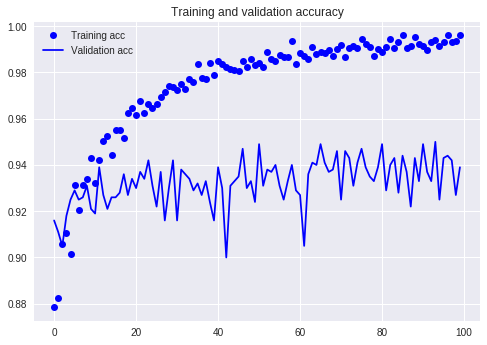

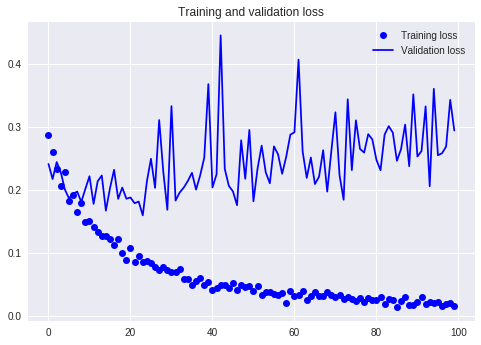

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


这些曲线看起来包含噪声。为了让图像更具可读性，你可以将每个损失和精度都替换为指数移动平均值，从而让曲线变得平滑。下面用一个简单的实用函数来实

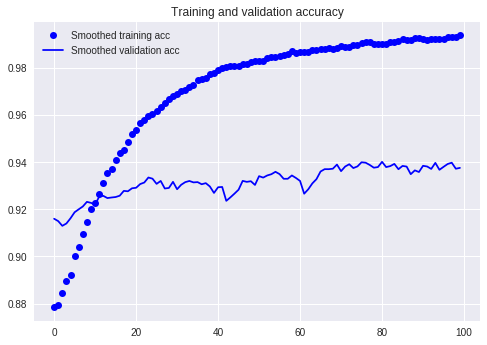

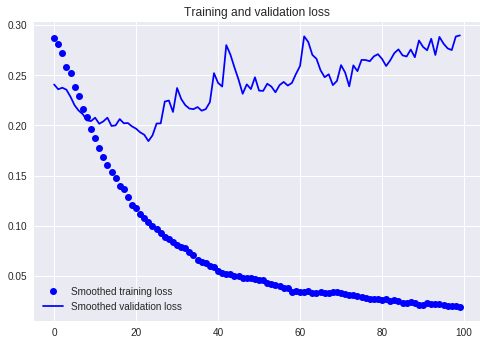

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


验证精度曲线变得更清楚。可以看到，精度值提高了 1%，从约 96% 提高到 97% 以上。

注意，从损失曲线上看不出与之前相比有任何真正的提高（实际上还在变差）。你可能感到奇怪，如果损失没有降低，那么精度怎么能保持稳定或提高呢？答案很简单：图中展示的是逐点（pointwise）损失值的平均值，但影响精度的是损失值的分布，而不是平均值，因为精度是模型预测的类别概率的二进制阈值。即使从平均损失中无法看出，但模型也仍然可能在改进。

现在，你可以在测试数据上最终评估这个模型。

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9379999947547912



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

下面是你应该从以上两节的练习中学到的要点。

* 卷积神经网络是用于计算机视觉任务的最佳机器学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且得到的结果还不错。
* 在小型数据集上的主要问题是过拟合。在处理图像数据时，数据增强是一种降低过拟合的强大方法。
* 利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集。对于小型图像数据集，这是一种很有价值的方法。
* 作为特征提取的补充，你还可以使用微调，将现有模型之前学到的一些数据表示应用于新问题。这种方法可以进一步提高模型性能。

现在你已经拥有一套可靠的工具来处理图像分类问题，特别是对于小型数据集。